In [3]:
# Might need to install some extra dependencies first to run this:
# !pip install --user vega seaborn
# !jupyter nbextension install --user --py vega3
# !jupyter nbextension enable vega3 --user --py

In [4]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
from pylab import rcParams
rcParams['figure.figsize'] = 6, 6
rcParams['figure.dpi'] = 150

In [50]:
# These functions will soon move into fast-manipulator / fast-plotter
import re
import os
import numpy as np
import pandas as pd
from pandas.api.types import is_string_dtype

# Interpret the filename
def get_read_options(filename):
    decipher = re.compile(r"tbl_(?P<index>.*?)(|--(?P<weights>.*))\.csv")
    groups = decipher.match(os.path.basename(filename))
    
    index_cols = groups.group("index").split(".")
    options = dict(index_col = range(len(index_cols)),
                   comment = "#"
                   )
    return options
    
def read_binned_df(filename):
    return pd.read_csv(filename, **get_read_options(filename))

def split_df(df, first_values, level=0):
    second = df.drop(first_values, level=level)
    second_values = second.index.unique(level=level)
    first = df.drop(second_values, level=level)
    return first, second

def split_data_sims(df, data_labels=["data"], dataset_level="dataset"):
    return split_df(df, first_values=data_labels, level=dataset_level)

def calculate_error(df, sumw2_label="sumw2", err_label="err", inplace=True):
    if not inplace:
        df = df.copy()
    for column in df:
        if sumw2_label in column:
            err_name = column.replace(sumw2_label, err_label)
            df[err_name] = np.sqrt(df[column])
    if not inplace:
        return df

def stack_sims(df, data_labels=["data"], dataset_level="dataset"):
    data, sims = split_data_sims(df, data_labels=data_labels, dataset_level=dataset_level)
    dataset_level_no = sims.index.names.index(dataset_level)
    group_levels = range(sims.index.nlevels)
    group_levels.remove(dataset_level_no)
    sim_stacked = sims.groupby(level=group_levels).cumsum()
    return data.append(sim_stacked)


_interval_regex = r"^(?P<open>[[(])"
_interval_regex += r"(?P<low>-inf|[0-9][.0-9]*)"
_interval_regex += r"\s*,\s*"
_interval_regex += r"(?P<high>\+?inf|[0-9][.0-9]*)"
_interval_regex += r"(?P<close>[)\]])$"


def interval_from_string(series):
    if not is_string_dtype(series):
        return series
    extracted = series.str.extract(_interval_regex)
    extracted = extracted.dropna()
    if len(extracted) != len(series):
        return series
    left_closed = extracted.open.unique()
    right_closed = extracted.close.unique()
    if len(right_closed) != 1 or len(right_closed) != 1:
        return series
    left_closed = left_closed[0] == "["
    right_closed = right_closed[0] == "]"
    if left_closed:
        if right_closed:
            closed = "both"
        else:
            closed = "left"
    else:
        if right_closed:
            closed = "right"
        else:
            closed = "neither"
    interval = pd.IntervalIndex.from_arrays(left=pd.to_numeric(extracted.low), 
                                            right=pd.to_numeric(extracted.high), 
                                            closed=closed)
    return interval

## Load in the data

In [7]:
!column -s, -t "example_outputs/tbl_dataset.nMuons.nIsoMuons--weighted.csv" |head

dataset     nMuons  nIsoMuons  n         weighted:sumw  weighted:sumw2
data        0       0          227265.0  227265.0       227265.0
data        1       0          17795.0   17795.0        17795.0
data        1       1          205616.0  205616.0       205616.0
data        2       0          107.0     107.0          107.0
data        2       1          2393.0    2393.0         2393.0
data        2       2          16207.0   16207.0        16207.0
data        3       3          1.0       1.0            1.0
dy          0       0          2181.0    787.2786       553.8454
dy          1       0          2472.0    910.05237      678.6613


In [8]:
muons = read_binned_df("example_outputs/tbl_dataset.nMuons.nIsoMuons--weighted.csv")
muons.head(10)

n  weighted:sumw  weighted:sumw2
dataset nMuons nIsoMuons                                         
data    0      0          227265.0   227265.00000     227265.0000
        1      0           17795.0    17795.00000      17795.0000
               1          205616.0   205616.00000     205616.0000
        2      0             107.0      107.00000        107.0000
               1            2393.0     2393.00000       2393.0000
               2           16207.0    16207.00000      16207.0000
        3      3               1.0        1.00000          1.0000
dy      0      0            2181.0      787.27860        553.8454
        1      0            2472.0      910.05237        678.6613
               1           29027.0    13163.78700       9294.2890

## Project 2D to 1D vs datasets

In [9]:
muons_1d = muons.groupby(level=("dataset", "nMuons")).sum()
muons_1d.head(8)

n  weighted:sumw  weighted:sumw2
dataset nMuons                                         
data    0       227265.0  227265.000000   227265.000000
        1       223411.0  223411.000000   223411.000000
        2        18707.0   18707.000000    18707.000000
        3            1.0       1.000000        1.000000
dy      0         2181.0     787.278600      553.845400
        1        31499.0   14073.839370     9972.950300
        2        44048.0   19253.873970    10659.372630
        3            1.0       0.518289        0.268624

In [10]:
muons_1d = calculate_error(muons_1d, inplace=False)
muons_1d.head(8)

n  weighted:sumw  weighted:sumw2  weighted:err
dataset nMuons                                                       
data    0       227265.0  227265.000000   227265.000000    476.723190
        1       223411.0  223411.000000   223411.000000    472.663728
        2        18707.0   18707.000000    18707.000000    136.773535
        3            1.0       1.000000        1.000000      1.000000
dy      0         2181.0     787.278600      553.845400     23.533920
        1        31499.0   14073.839370     9972.950300     99.864660
        2        44048.0   19253.873970    10659.372630    103.244238
        3            1.0       0.518289        0.268624      0.518289

## Plotting 1D Data vs MC using Vega-lite
Plot things using Vega-lite:  
* Not a complete solution yet, eg: errorbars not working in notebook, etc, but is a way to go for the future
* Advantages: Reproducibility, interactivity

In [11]:
# Stack the values from MC; Vega-lite should be able to do this, but I've had problems...
stacked_df = stack_sims(muons_1d)

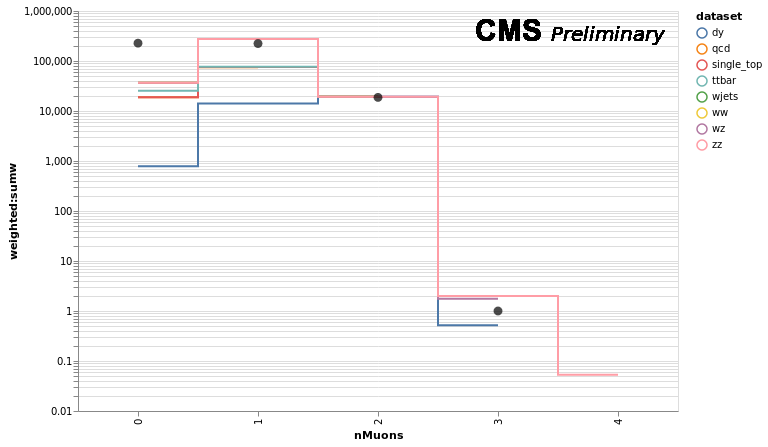

In [12]:
spec = {
   '$schema': 'https://vega.github.io/schema/vega-lite/v2.json',
   'config': {},
   'width': 600,
   'height': 400,
   'layer': [{
       "selection": {"grid": {"type": "interval", "bind": "scales"}},
       "mark": {"type": "line", "interpolate": "step","tooltip": {"field": ""}},
       "encoding": {
           "y": {
               "field": "weighted:sumw",
               "type": "quantitative", 
               "scale": {"type": "log", "domain": [0.01]}
           },
           "tooltip": [{"field": "weighted:sumw"}, {"field": "weighted:err"}],
           "color": {"field": "dataset", "type": "nominal"}
       },
       "transform": [{"filter": "datum.dataset != 'data'"}]
   },{
       "mark": {"type": "point", "filled": "true", "size": 80, "color": "black"},
       "encoding": {
           "y": {"field": "weighted:sumw","type": "quantitative"},
           "tooltip": [{"field": "weighted:sumw"}, {"field": "weighted:err"}]
       },
       "transform": [{"filter": "datum.dataset == 'data'"}]
   },{
       "mark": {"type": "text", "text": "CMS", "size": 30, "font": "Arial", "fontWeight": "bold"},
       "encoding": {"x": {"value": 430}, "y": {"value": 30}}
   },{
       "mark": {"type": "text", "text": "Preliminary", "size": 20, "fontStyle": "italic", "fontWeight": 5},
       "encoding": {"x": {"value": 530}, "y": {"value": 30}}
   }
   ],
    'encoding': {
        "x": {"field": "nMuons", "type": "ordinal", "grid": "true"}
    }
}
from vega import VegaLite
plot = VegaLite(spec, stacked_df.reset_index())
plot

## Plotting 1D Data vs MC using Matplotlib and built-in pandas

In [13]:
mu_data, mu_sims = split_data_sims(muons_1d)
mu_data

n  weighted:sumw  weighted:sumw2  weighted:err
dataset nMuons                                                       
data    0       227265.0       227265.0        227265.0    476.723190
        1       223411.0       223411.0        223411.0    472.663728
        2        18707.0        18707.0         18707.0    136.773535
        3            1.0            1.0             1.0      1.000000

In [14]:
mu_sims.head()

n  weighted:sumw  weighted:sumw2  weighted:err
dataset nMuons                                                      
dy      0        2181.0     787.278600    5.538454e+02     23.533920
        1       31499.0   14073.839370    9.972950e+03     99.864660
        2       44048.0   19253.873970    1.065937e+04    103.244238
        3           1.0       0.518289    2.686235e-01      0.518289
qcd     0         124.0   18058.283000    2.539280e+07   5039.127107

Text(0.64,0.932,'Preliminary')

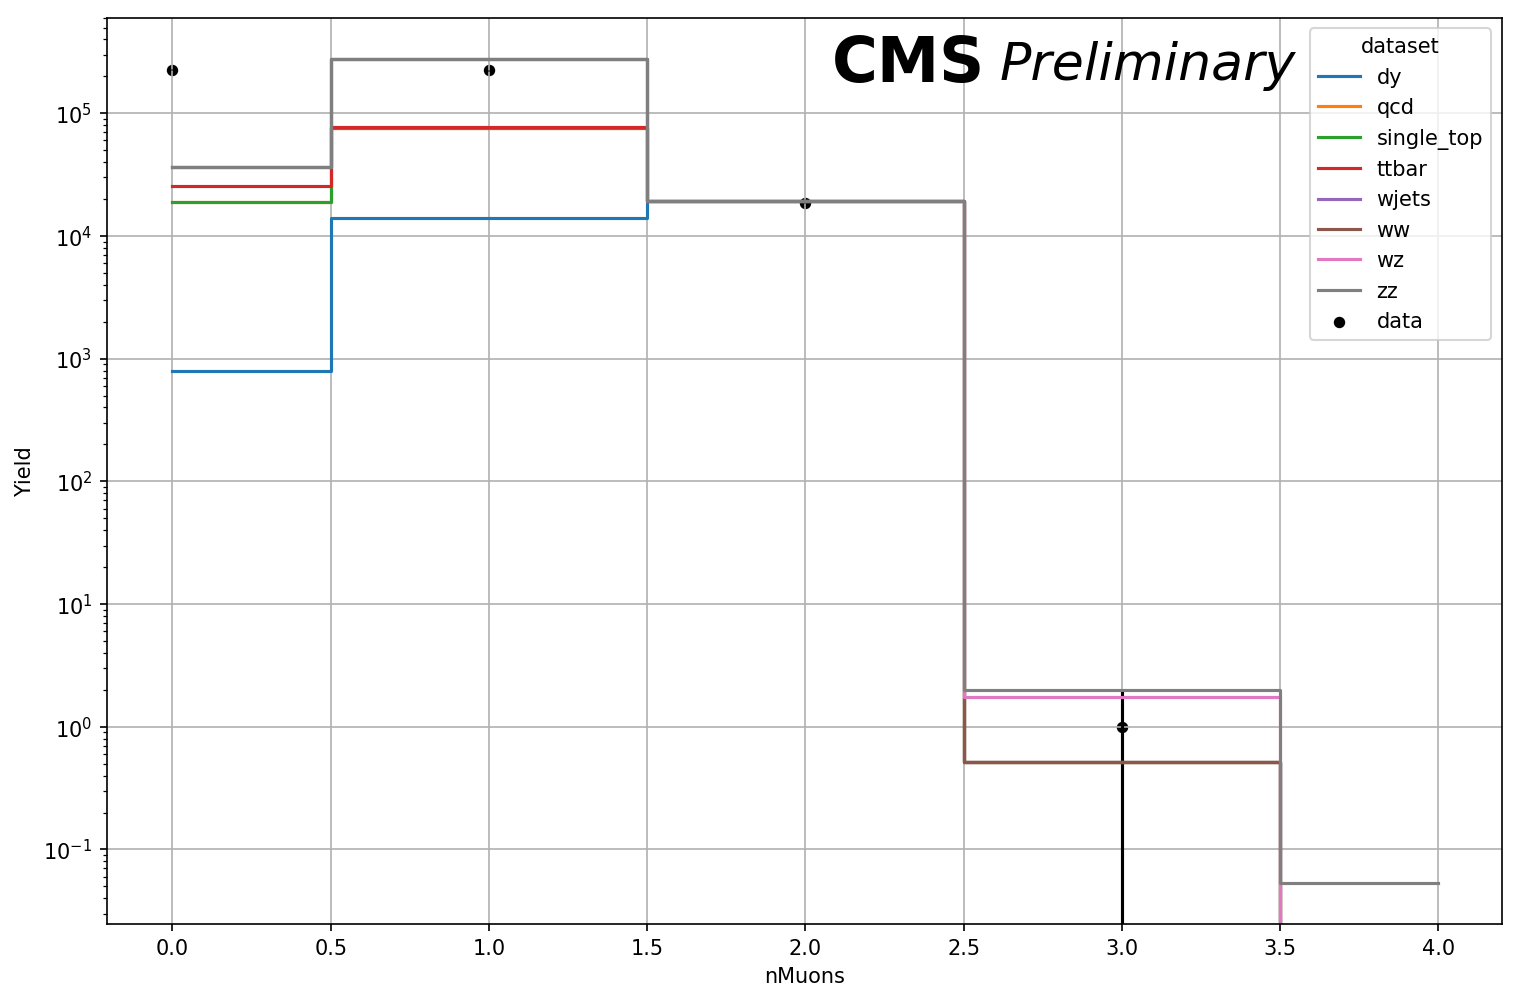

In [15]:
ax = plt.subplot(111)

mu_sims["weighted:sumw"].unstack(0).plot.line(drawstyle="steps-mid", logy=True, stacked=True, figsize=(12, 8), ax=ax)
mu_data.reset_index().plot.scatter(x="nMuons", y="weighted:sumw", yerr="weighted:err", color="k", label="data", ax=ax)

plt.grid(True)
plt.ylabel("Yield")
plt.annotate("CMS", (0.52, 0.93), xycoords="axes fraction",fontsize=30, fontweight="bold")
plt.annotate("Preliminary", (0.64, 0.932), xycoords="axes fraction",fontsize=25, fontstyle="italic")

## 2D heat-map plots

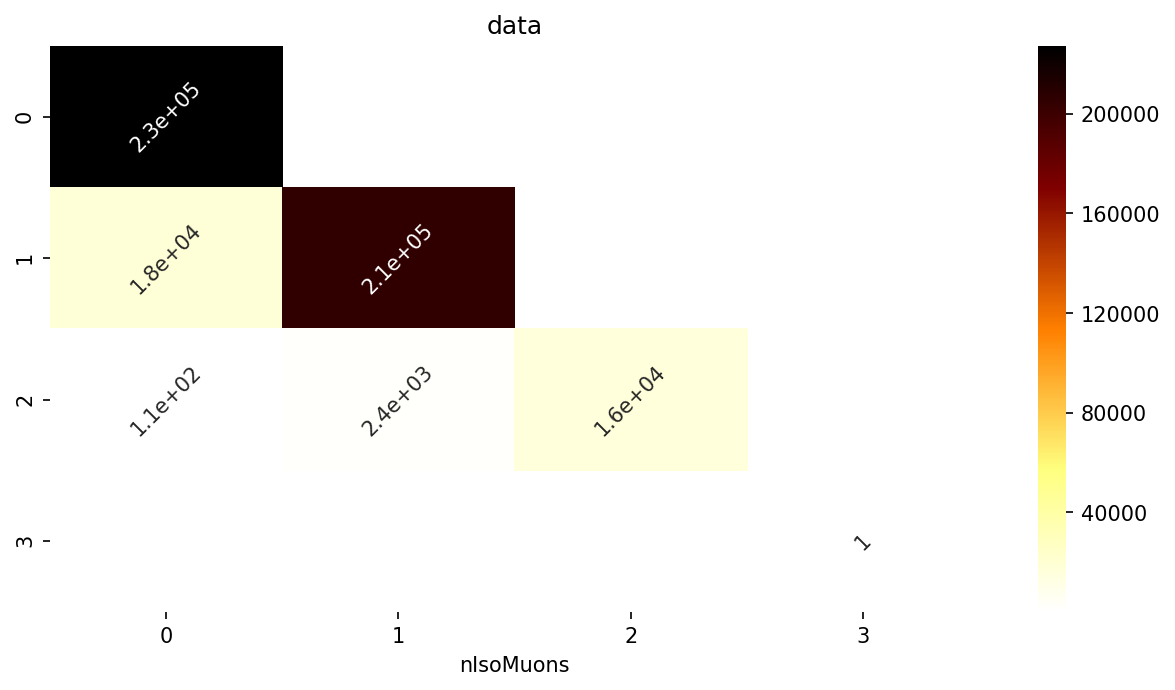

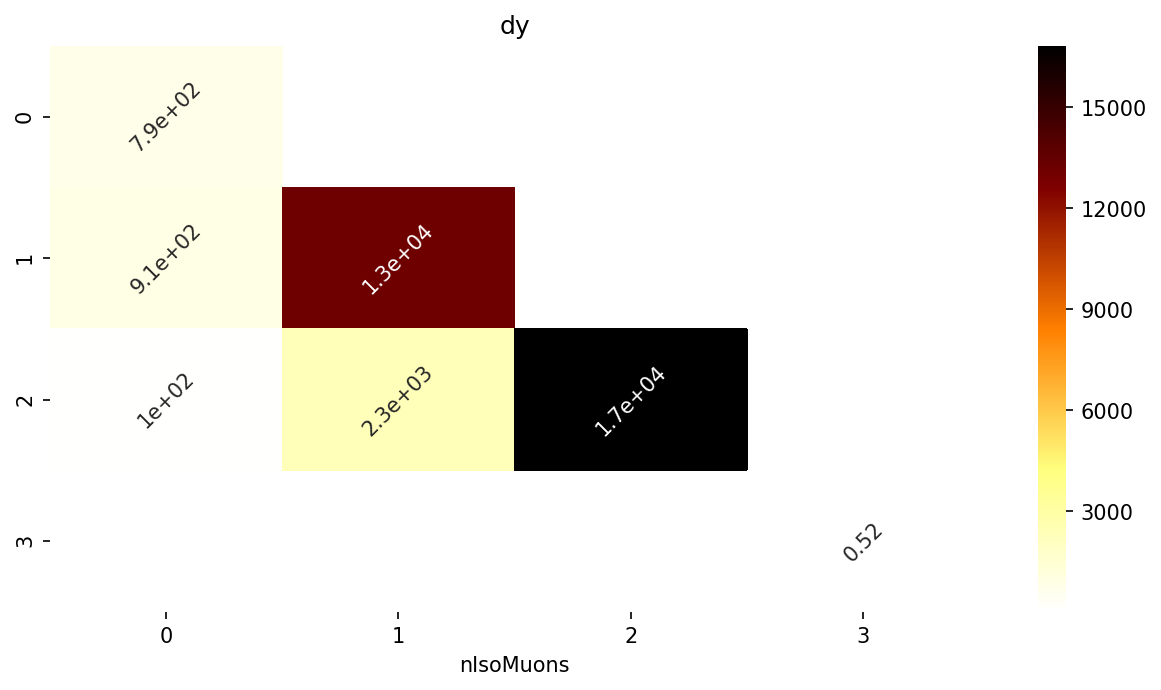

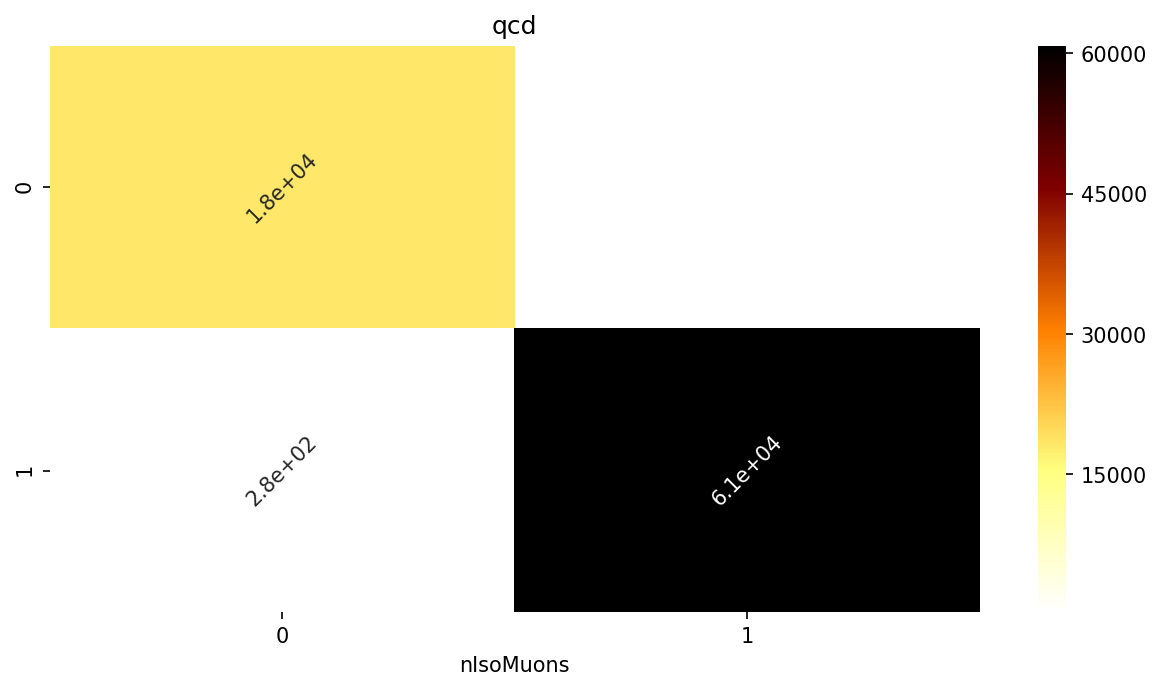

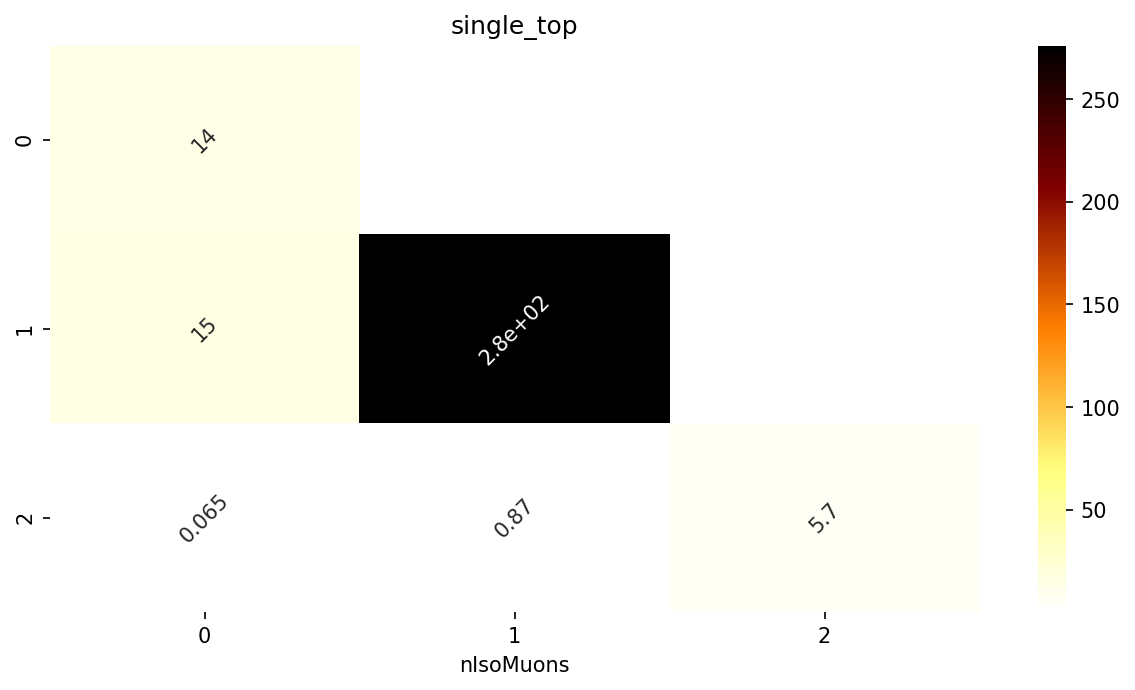

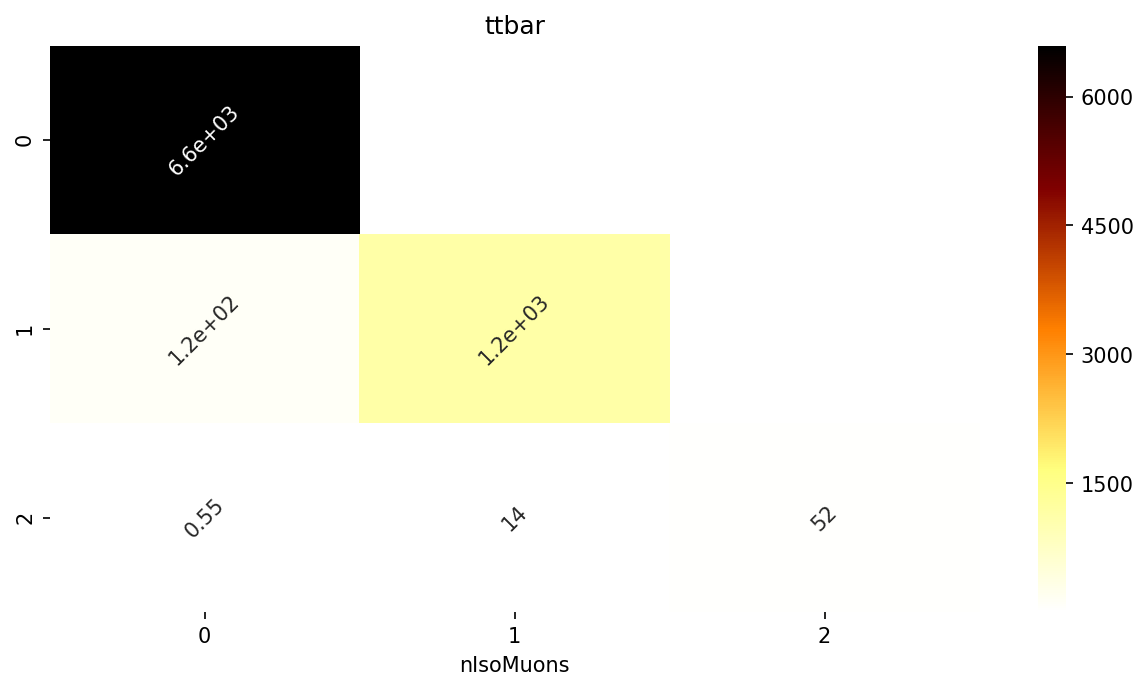

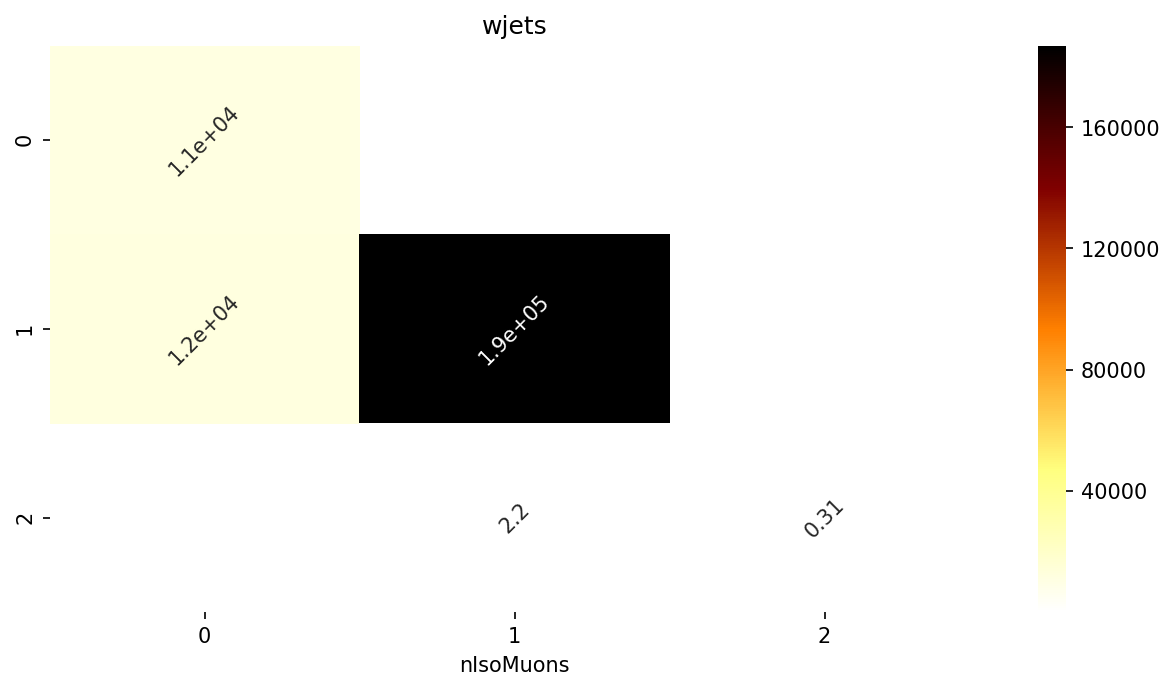

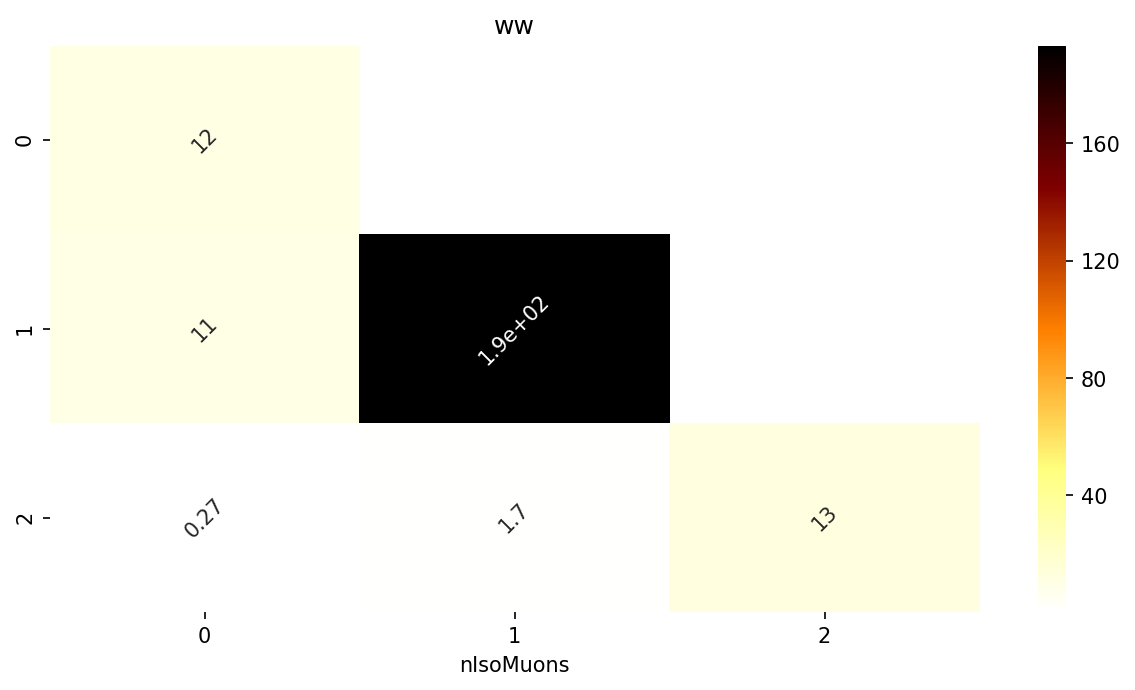

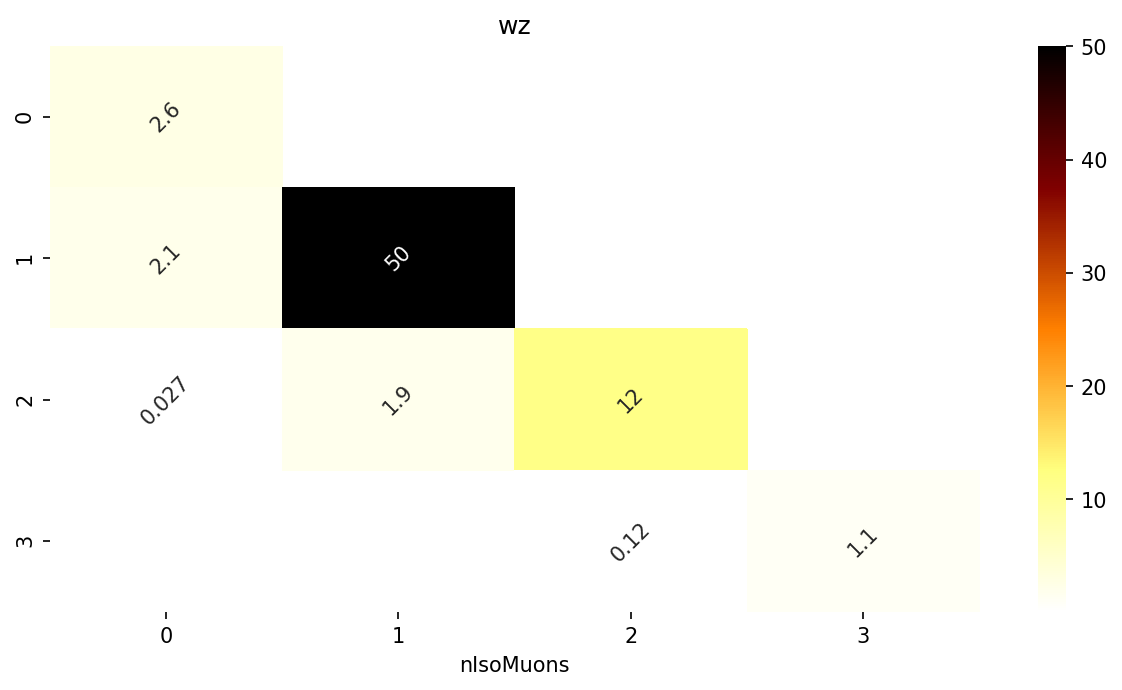

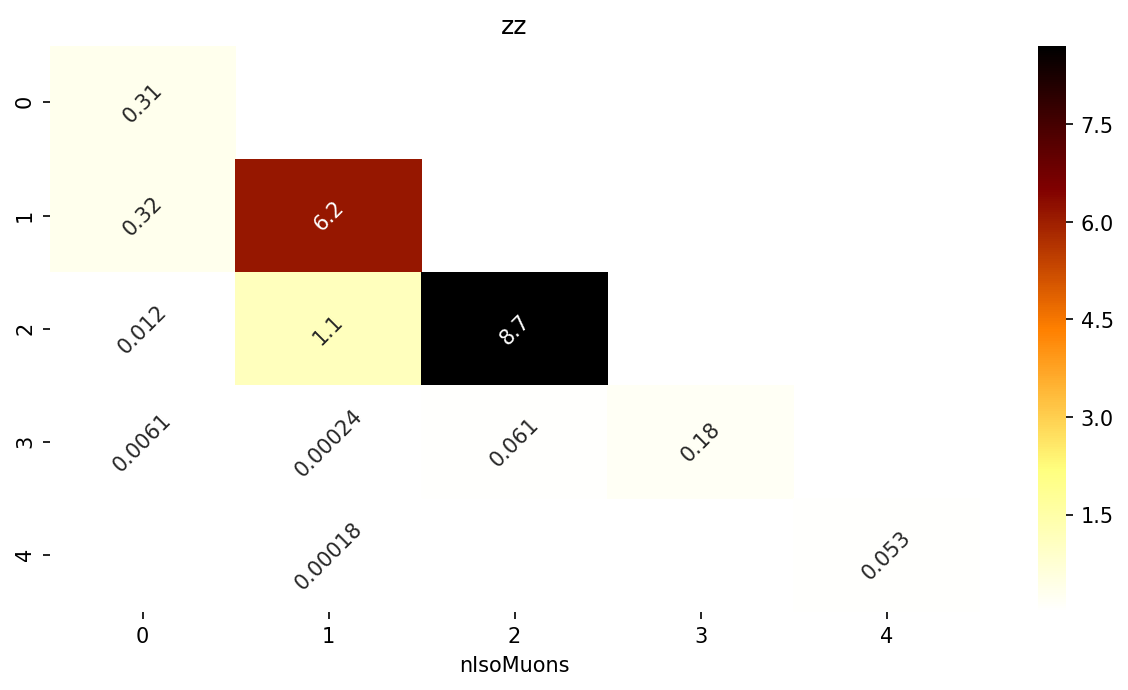

In [16]:
import seaborn as sns

values = "weighted:sumw"
y = "nMuons"
x = "nIsoMuons"
dataframe = muons.reset_index()
for dataset, group in dataframe.groupby("dataset"):
    df = group.pivot(index=y, columns=x, values=values)
    df = df.reset_index(0, drop=True)
                                      
    plt.figure(figsize=(10, 5))
    plt.title(dataset)
    sns.heatmap(df, cmap="afmhot_r",annot=True, annot_kws={"rotation": 45})

## Plot the Dimuon data
Uses an "interval index"

In [94]:
dimuon = read_binned_df("example_outputs/tbl_dataset.dimu_mass--weighted.csv")
dimuon.head()

n  weighted:sumw  weighted:sumw2
dataset dimu_mass                                          
data    (-inf, 60.0]  1107.0         1107.0          1107.0
        (60.0, 61.0]    40.0           40.0            40.0
        (61.0, 62.0]    25.0           25.0            25.0
        (62.0, 63.0]    23.0           23.0            23.0
        (63.0, 64.0]    28.0           28.0            28.0

In [95]:
intervals = interval_from_string(dimuon.index.levels[1])
intervals

IntervalIndex([(-inf, 60.0], (100.0, 101.0], (101.0, 102.0], (102.0, 103.0], (103.0, 104.0] ... (95.0, 96.0], (96.0, 97.0], (97.0, 98.0], (98.0, 99.0], (99.0, 100.0]]
              closed='right',
              dtype='interval[float64]')

In [96]:
dimuon.index.set_levels(intervals.mid, level=1, inplace=True)
dimuon.iloc[range(5) + range(-5, 0)]

n  weighted:sumw  weighted:sumw2
dataset dimu_mass                                         
data    -inf         1107.0    1107.000000     1107.000000
         60.500000     40.0      40.000000       40.000000
         61.500000     25.0      25.000000       25.000000
         62.500000     23.0      23.000000       23.000000
         63.500000     28.0      28.000000       28.000000
zz       116.500000     0.0       0.000000        0.000000
         117.500000     1.0       0.008529        0.000073
         118.500000     1.0       0.003322        0.000011
         119.500000     1.0       0.008755        0.000077
         inf           45.0       0.321121        0.002643

(0.7, 10000.0)

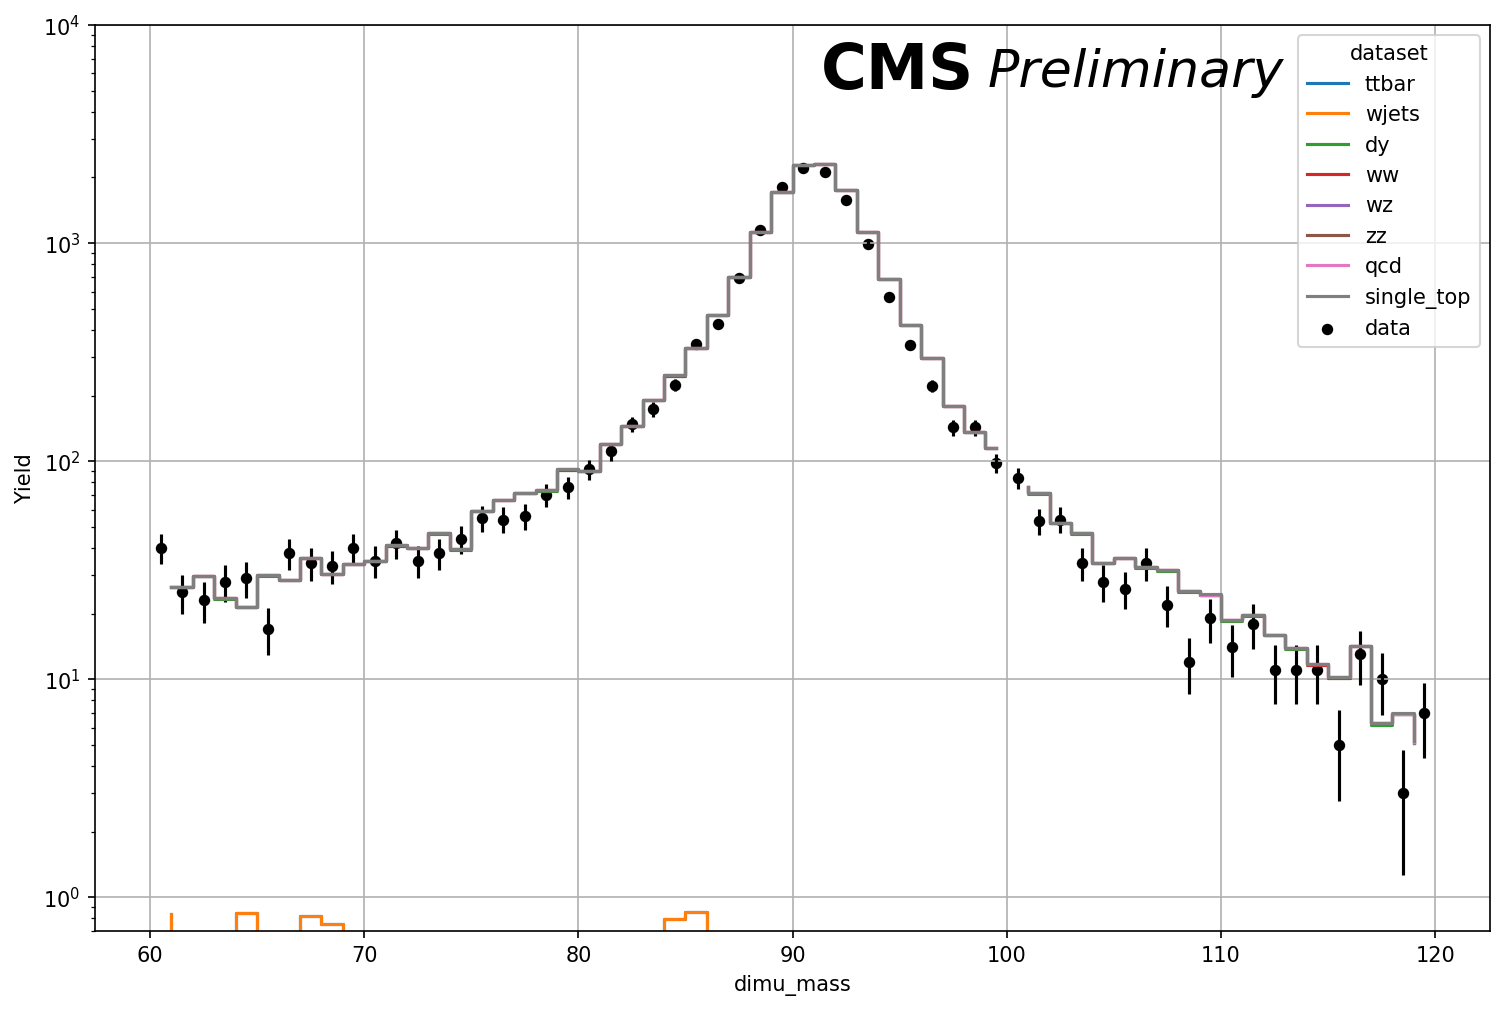

In [100]:
order = ["data", "ttbar", "wjets", "dy", "ww", "wz", "zz", "qcd", "single_top"]
dimuon = dimuon.reindex(order, axis=0, level=0)

calculate_error(dimuon, inplace=True)
dimu_data, dimu_sims = split_data_sims(dimuon)
ax = plt.subplot(111)

dimu_sims["weighted:sumw"].unstack(0).plot.line(drawstyle="steps-mid", logy=True, stacked=True, figsize=(12, 8), ax=ax)
dimu_data.reset_index().plot.scatter(x="dimu_mass", y="weighted:sumw", yerr="weighted:err", color="k", label="data", ax=ax)

plt.grid(True)
plt.ylabel("Yield")
plt.annotate("CMS", (0.52, 0.93), xycoords="axes fraction",fontsize=30, fontweight="bold")
plt.annotate("Preliminary", (0.64, 0.932), xycoords="axes fraction",fontsize=25, fontstyle="italic")
plt.ylim([0.7, 1e4])